In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline
import os
if os.getcwd().endswith('tools'):
    os.chdir('..')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import json

from tools.local_datasets import get_metadata
from MLUtilities.dataset.io import load_features, load_data_set

from sklearn.datasets import make_blobs, make_classification
from sklearn.cross_validation import train_test_split, ShuffleSplit

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from scipy.stats import entropy
from scipy.stats import norm
from sklearn.metrics.pairwise import pairwise_distances

C:\Program Files\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
np.random.seed(0)

centers = [[0, 1], [-2, -2], [1, -1]]
n_samples = [1000, 1500, 500]
stds = [.8, 1.2, .5]
n_clusters = len(centers)

X = []
y = []
for c in range(n_clusters):
    xi, yi = make_blobs(n_samples=n_samples[c], centers=[centers[c]], cluster_std=stds[c], shuffle=False)
    X.append(xi)
    y.append(yi+c)
X = np.concatenate(X)
y = np.concatenate(y)

# get some labeled data
# L = np.random.randint(0, y.shape[0]+1, size=200)
cv = ShuffleSplit(n=y.shape[0], n_iter=1, train_size=.1, test_size=None)
for L, U in cv:
    pass

# dataframe representation of features
dff = pd.DataFrame(X)

L = pd.Index(L).sort_values()
U = pd.Index(U).sort_values()

XL = dff.loc[L, :].values
yL = y.take(L.values)
XU = dff.loc[U, :].values
yU = y.take(U.values)

# XL, XU, yL, yU = train_test_split(X, y, train_size=.1)
print 'Labeled size:', XL.shape
print 'Unlabeled size:', XU.shape

Labeled size: (300L, 2L)
Unlabeled size: (2700L, 2L)


In [4]:
est_centers = []
for c in range(n_clusters):
    est_centers.append(np.mean(XL[np.where(yL == c)[0], :], axis=0))
est_centers = np.asarray(est_centers)
alg = KMeans(n_clusters=3, init=est_centers, n_init=1, max_iter=1)
alg.fit(est_centers)

KMeans(algorithm='auto', copy_x=True,
    init=array([[-0.05774,  1.12711],
       [-2.09264, -2.11893],
       [ 0.91667, -0.93439]]),
    max_iter=1, n_clusters=3, n_init=1, n_jobs=1,
    precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

In [5]:
alg2 = NearestNeighbors(n_neighbors=1, n_jobs=4, algorithm='brute')
print np.bincount(yL)
alg2.fit(XL, yL)

[ 91 155  54]


NearestNeighbors(algorithm='brute', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=4, n_neighbors=1, p=2, radius=1.0)

In [6]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .05     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.stack((xx.ravel(), yy.ravel())).T

In [7]:
# Obtain labels for each point in mesh. Use last trained model.
H = alg.transform(Xmesh)
H = np.apply_along_axis(entropy, 1, H / H.sum(axis=1, keepdims=True))

# Put the result into a color plot
H = H.reshape(xx.shape)

In [8]:
def dist_entropy_sum(D_closest):
    return 1. / (1. / D_closest.D).sum(axis=0)

def dist_entropy_min2(D):
    min_values = D_closest.D.min(axis=1)  # == min distances
    # min distances / second min distances =
    return min_values / D_closest.D.where(D_closest.D.gt(min_values, axis=0),).min(axis=1)

def dist_certainty_class(D_closest, y):
    return D_closest.D.idxmin(axis=1).values == y

In [9]:
from ml.distancematrix import MinDistanceMatrix
D = MinDistanceMatrix.from_labeled_features(dff, yL, L, U, n_classes=n_clusters)

H_sum = dist_entropy_sum(D)
H_sum = H_sum.reshape(xx.shape)
H_min2 = dist_entropy_min2(D)
H_min2 = H_min2.reshape(xx.shape)
H_cert = dist_certainty_class(D, 2)
H_cert = H_cert.reshape(xx.shape)
print 'Done.'

C:\Program Files\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


ValueError: total size of new array must be unchanged

TypeError: Invalid dimensions for image data

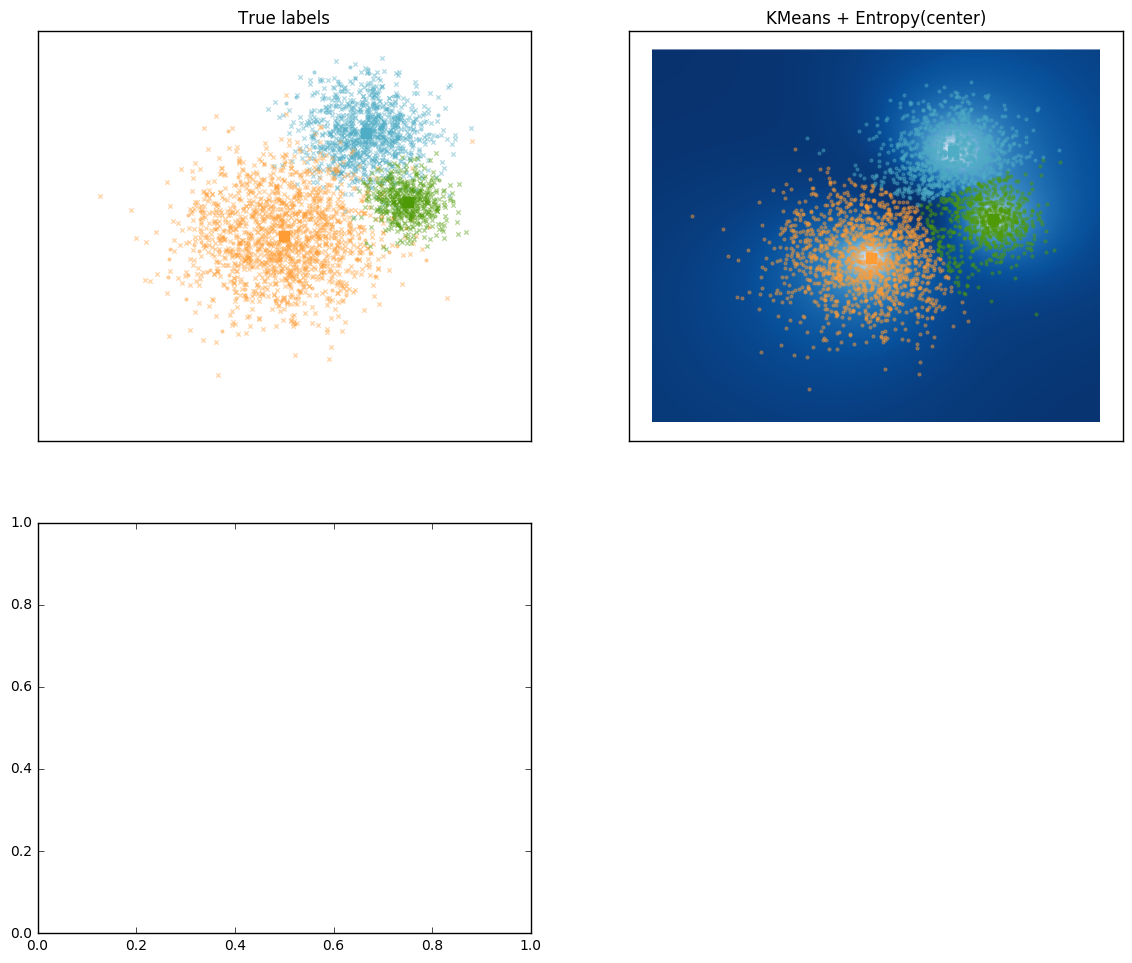

In [10]:
fig = plt.figure(figsize(14,18))
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

n_plots = 6
n_cols = 2
n_rows = n_plots // 2

# TRUE LABELS
#############

ax = fig.add_subplot(n_rows, n_cols, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = yL == k
    cluster_center = centers[k]
    ax.scatter(XL[my_members, 0], XL[my_members, 1], color=col, s=4, alpha=.4)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, s=50, marker='s')
    
    my_members = yU == k
    ax.scatter(XU[my_members, 0], XU[my_members, 1], color=col, s=10, alpha=.4, marker='x')
ax.set_title('True labels')
ax.set_xticks(())
ax.set_yticks(())

## ENTROPY
##########


ax = fig.add_subplot(n_rows, n_cols, 2)
plt.imshow(H, interpolation='None',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')
# Samples
k_means_cluster_centers = alg.cluster_centers_
y = alg.predict(X)
for k, col in zip(range(n_clusters), colors):
    my_members = y == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(X[my_members, 0], X[my_members, 1], color=col, s=4, alpha=.4)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, s=50, marker='s')
ax.set_title('KMeans + Entropy(center)')
ax.set_xticks(())
ax.set_yticks(())


## DISTANCE-based ENTROPY

# plot
ax = fig.add_subplot(n_rows, n_cols, 3)
plt.imshow(H_sum, interpolation='None',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')
# Samples
k_means_cluster_centers = alg.cluster_centers_
# y = alg.predict(X)
for k, col in zip(range(n_clusters), colors):
    my_members = yL == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(XL[my_members, 0], XL[my_members, 1], color=col, s=4, alpha=.4)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, s=50, marker='s')
ax.set_title('1NN + sum of min(D) per class')
ax.set_xticks(())
ax.set_yticks(())

# plot
ax = fig.add_subplot(n_rows, n_cols, 4)
plt.imshow(H_min2, interpolation='None',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')
# Samples
k_means_cluster_centers = alg.cluster_centers_
# y = alg.predict(X)
for k, col in zip(range(n_clusters), colors):
    my_members = yL == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(XL[my_members, 0], XL[my_members, 1], color=col, s=4, alpha=.4)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, s=50, marker='s')
ax.set_title('1NN + min/min_2')
ax.set_xticks(())
ax.set_yticks(())

# label certainty for label 0
ax = fig.add_subplot(n_rows, n_cols, 5)
plt.imshow(H_cert, interpolation='None',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')
# Samples
k_means_cluster_centers = alg.cluster_centers_
# y = alg.predict(X)
for k, col in zip(range(n_clusters), colors):
    my_members = yL == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(XL[my_members, 0], XL[my_members, 1], color=col, s=4, alpha=.4)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, s=50, marker='s')
ax.set_title('Certainty for label 0')
ax.set_xticks(())
ax.set_yticks(())

# combined label certain + entropy
ax = fig.add_subplot(n_rows, n_cols, 6)
plt.imshow(H_cert * norm.pdf(H_min2, loc=.5, scale=.05), interpolation='None',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')
# Samples
k_means_cluster_centers = alg.cluster_centers_
# y = alg.predict(X)
for k, col in zip(range(n_clusters), colors):
    my_members = yL == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(XL[my_members, 0], XL[my_members, 1], color=col, s=4, alpha=.4)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, s=50, marker='s')
ax.set_title('Certainty * (1NN + min/min_2)')
ax.set_xticks(())
ax.set_yticks(())

plt.subplots_adjust(hspace=.1, wspace=.1)

In [11]:
def dist_entropy_sum(D_closest):
    return 1./np.sum(1./D_closest, axis=0)

def dist_entropy_min2(D_closest):
    sortD = np.argsort(D_closest, axis=0)
    return D_closest[sortD[0, :], xrange(D_closest.shape[1])] / D_closest[sortD[1, :], xrange(D_closest.shape[1])]

def softmax(Z, axis=1):
    Zexp = np.exp(Z)
    Zsum = np.sum(Zexp, axis=axis, keepdims=True)
    return Zexp / Zsum

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
sns.set('notebook', 'whitegrid', 'Greys')

Compute pairwise distances...
Done.


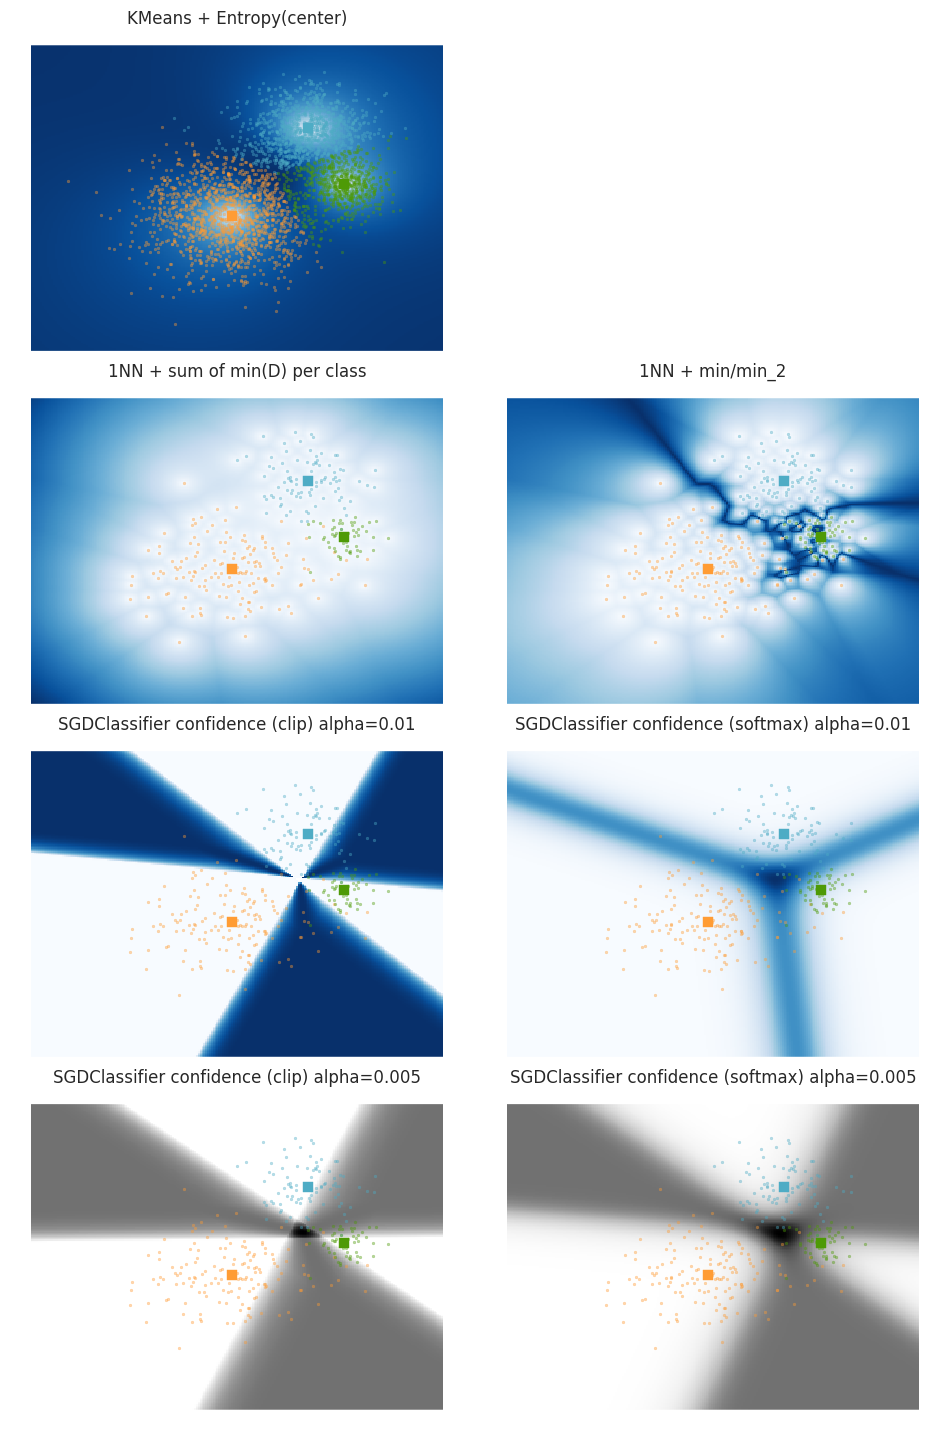

In [43]:
fig = plt.figure(figsize(12,18))
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .05     # point in the mesh [x_min, x_max]x[y_min, y_max].
n_plots = 4
nrows = 4

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.stack((xx.ravel(), yy.ravel())).T

## ENTROPY
# ===========================

# Obtain labels for each point in mesh. Use last trained model.
H = alg.transform(Xmesh)
H = np.apply_along_axis(entropy, 1, H / H.sum(axis=1, keepdims=True))

# Put the result into a color plot
H = H.reshape(xx.shape)
ax = fig.add_subplot(nrows,2,1)
plt.imshow(H, interpolation='None',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')
# Samples
k_means_cluster_centers = alg.cluster_centers_
y = alg.predict(X)
for k, col in zip(range(n_clusters), colors):
    my_members = y == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(X[my_members, 0], X[my_members, 1], color=col, s=4, alpha=.4)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, s=50, marker='s')
ax.set_title('KMeans + Entropy(center)')
ax.set_xticks(())
ax.set_yticks(())


## DISTANCE-based ENTROPY
# ===========================

print 'Compute pairwise distances...'
D = pairwise_distances(XL, Xmesh, n_jobs=4)
closest_class_neighbors = []
for c in range(n_clusters):
    closest_class_neighbors.append( np.min(D.take(np.where(yL == c)[0], axis=0), axis=0) )
closest_class_neighbors = np.stack(closest_class_neighbors)

H_sum = dist_entropy_sum(closest_class_neighbors)
H_sum = H_sum.reshape(xx.shape)
H_min2 = dist_entropy_min2(closest_class_neighbors)
H_min2 = H_min2.reshape(xx.shape)
print 'Done.'

# plot
ax = fig.add_subplot(nrows,2,3)
plt.imshow(H_sum, interpolation='None',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')
# Samples
k_means_cluster_centers = alg.cluster_centers_
# y = alg.predict(X)
for k, col in zip(range(n_clusters), colors):
    my_members = yL == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(XL[my_members, 0], XL[my_members, 1], color=col, s=4, alpha=.4)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, s=50, marker='s')
ax.set_title('1NN + sum of min(D) per class')
ax.set_xticks(())
ax.set_yticks(())

# plot
ax = fig.add_subplot(nrows,2,4)
plt.imshow(H_min2, interpolation='None',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')
# Samples
k_means_cluster_centers = alg.cluster_centers_
# y = alg.predict(X)
for k, col in zip(range(n_clusters), colors):
    my_members = yL == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(XL[my_members, 0], XL[my_members, 1], color=col, s=4, alpha=.4)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, s=50, marker='s')
ax.set_title('1NN + min/min_2')
ax.set_xticks(())
ax.set_yticks(())

# Confidence based entropy
# ===========================
sgdclf = SGDClassifier(alpha=.01, class_weight='balanced')
sgdclf.fit(XL, yL)
D = sgdclf.decision_function(Xmesh)

Dsmax = softmax(D)
H_conf_smax = np.apply_along_axis(entropy, 1, Dsmax)
H_conf_smax = H_conf_smax.reshape(xx.shape)

D[D < -1] = -1.
D[D > 1] = 1.
D = (D + 1.) / 2.
H_conf = np.apply_along_axis(entropy, 1, D)
H_conf = H_conf.reshape(xx.shape)


# plot
ax = fig.add_subplot(nrows,2,5)
plt.imshow(H_conf, interpolation='None',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')
# Samples
k_means_cluster_centers = alg.cluster_centers_
# y = alg.predict(X)
for k, col in zip(range(n_clusters), colors):
    my_members = yL == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(XL[my_members, 0], XL[my_members, 1], color=col, s=4, alpha=.4)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, s=50, marker='s')
ax.set_title('SGDClassifier confidence (clip) alpha={}'.format(sgdclf.alpha))
ax.set_xticks(())
ax.set_yticks(())


# plot
ax = fig.add_subplot(nrows,2,6)
plt.imshow(H_conf_smax, interpolation='None',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')
# Samples
k_means_cluster_centers = alg.cluster_centers_
for k, col in zip(range(n_clusters), colors):
    my_members = yL == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(XL[my_members, 0], XL[my_members, 1], color=col, s=4, alpha=.4)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, s=50, marker='s')
ax.set_title('SGDClassifier confidence (softmax) alpha={}'.format(sgdclf.alpha))
ax.set_xticks(())
ax.set_yticks(())


# Confidence based entropy (native implementation)
# ===========================
sgdclf = SGDClassifier(alpha=.005, class_weight='balanced', loss='modified_huber', n_iter=50)
sgdclf.fit(XL, yL)
D = sgdclf.predict_proba(Xmesh)

sgdclf = SGDClassifier(alpha=.005, class_weight='balanced', loss='log', n_iter=50)
sgdclf.fit(XL, yL)
Dsmax= sgdclf.predict_proba(Xmesh)

# Dsmax = softmax(D)
H_conf_smax = np.apply_along_axis(entropy, 1, Dsmax)
H_conf_smax = H_conf_smax.reshape(xx.shape)

# D[D < -1] = -1.
# D[D > 1] = 1.
# D = (D + 1.) / 2.
H_conf = np.apply_along_axis(entropy, 1, D)
H_conf = H_conf.reshape(xx.shape)


# plot
ax = fig.add_subplot(nrows,2,7)
plt.imshow(H_conf, interpolation='None',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Greys,
           aspect='auto', origin='lower')
# Samples
k_means_cluster_centers = alg.cluster_centers_
# y = alg.predict(X)
for k, col in zip(range(n_clusters), colors):
    my_members = yL == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(XL[my_members, 0], XL[my_members, 1], color=col, s=4, alpha=.4)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, s=50, marker='s')
ax.set_title('SGDClassifier confidence (clip) alpha={}'.format(sgdclf.alpha))
ax.set_xticks(())
ax.set_yticks(())


# plot
ax = fig.add_subplot(nrows,2,8)
cax = plt.imshow(H_conf_smax, interpolation='None',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Greys,
           aspect='auto', origin='lower')

# divider = make_axes_locatable(ax)
# cb_ax = divider.append_axes("right", size="5%", pad=0.075)
# colorbar = fig.colorbar(cax, cax=cb_ax, ticks=np.linspace(*cax.get_clim(), num=6))
# colorbar.ax.tick_params(axis='y', color='k')

# Samples
k_means_cluster_centers = alg.cluster_centers_
for k, col in zip(range(n_clusters), colors):
    my_members = yL == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(XL[my_members, 0], XL[my_members, 1], color=col, s=4, alpha=.4)
    ax.scatter(cluster_center[0], cluster_center[1], color=col, s=50, marker='s')
ax.set_title('SGDClassifier confidence (softmax) alpha={}'.format(sgdclf.alpha))
ax.set_xticks(())
ax.set_yticks(())

sns.despine(left=True, bottom=True)
plt.subplots_adjust(hspace=.05, wspace=.05)

(1.7863980627429655e-06, 1.098538259152779)